In [25]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# fix import
# from preprocessing.func_preprocessing import gws_conversions, TS_derivative
def gws_conversions(dataset):
    dataset["P"] = gsw.conversions.p_from_z(dataset["depth"],
                                            dataset["latitude"])
    print(dataset["P"].shape)
    dataset['pot_temp'] = gsw.conversions.pt0_from_t(dataset.S,
                                                     dataset.T, dataset.P)
    # calculate Conservative Temperature from potential temperature
    dataset["CT"] = gsw.CT_from_pt(dataset['S'], dataset["pot_temp"])
    # calculate kappa using gsw_kappa function
    dataset["kappa"] = gsw.kappa(dataset["S"],
                                 dataset["CT"], dataset['S'])
    # calculate N^2 which is calculated for pressure midpoints
    N2, p_mid = gsw.Nsquared(dataset["S"].expand_dims(dim="new_axis", axis=-1), dataset["CT"], dataset["P"],
                             dataset["latitude"])
    #dataset['N2'] = (('DEPTH_MID',), N2)
    #dataset['DEPTH_MID'] = p_mid
    dataset['insitu_T'] = dataset["T"]
    dataset["T"] = dataset["pot_temp"]
    return dataset


def TS_derivative(dataset):
    dataset["dTdz"] = dataset.T.differentiate('depth')
    dataset['dSdz'] = dataset.S.differentiate('depth')
    return dataset

In [4]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/preprocessing/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/preprocessing/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl )

In [11]:
#arctic_ds = arctic_ds.rename_dims({'profiles': 'profile'})
arctic_ds = arctic_ds.assign_coords(longitude=arctic_ds['longitude'], latitude=arctic_ds['latitude'])

In [12]:
ds_combined = xr.concat([arctic_ds, alberto_ds],  dim="profile")

In [19]:
ds_combined = gws_conversions(ds_combined)
ds_combined = TS_derivative(ds_combined)
ds_combined

(69, 1222, 1)


<xarray.Dataset>
Dimensions:    (depth: 69, profile: 1222, single: 1)
Coordinates:
  * depth      (depth) int64 0 10 20 30 40 50 60 ... 620 630 640 650 660 670 680
    latitude   (depth, profile, single) float64 65.23 65.24 ... 75.51 76.75
    longitude  (depth, profile, single) float64 -166.6 -166.6 ... 18.66 9.366
Dimensions without coordinates: profile, single
Data variables:
    TIME       (depth, profile, single) float64 7.362e+05 7.362e+05 ... nan nan
    eps        (depth, profile) float64 1.177e-05 1.305e-06 ... nan nan
    PRESSURE   (profile, depth, single) float64 5.125 15.12 25.12 ... nan nan
    S          (depth, profile) float64 12.29 0.0 11.81 0.0 ... nan nan nan nan
    T          (depth, profile, single) float64 11.06 11.06 11.06 ... nan nan
    P          (depth, profile, single) float64 -0.0 -0.0 -0.0 ... nan nan nan
    pot_temp   (depth, profile, single) float64 11.06 11.06 11.06 ... nan nan
    CT         (depth, profile, single) float64 11.47 11.66 11.47 ... nan nan
    kappa      (depth, profile, single) float64 4.608e-10 4.749e-10 ... nan nan
    dTdz       (depth, profile, single) float64 nan nan nan nan ... nan nan nan
    dSdz       (depth, profile) float64 0.2048 0.0 -0.0511 0.0 ... nan nan nan
    insitu_T   (depth, profile) float64 11.06 11.06 11.06 12.34 ... nan nan nan

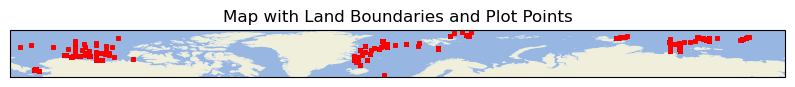

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(ds_combined["longitude"], ds_combined["latitude"], transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

In [20]:
df = ds_combined.to_dataframe()

In [22]:
global_ds

,T,S,z,gamma,dTdz,dSdz,lat,lon,log_eps,log_kappa,log_N2_sort,hab,depth,cruise,profile
0,0.594316,34.733891,-3835.0,28.214811,0.002297,0.000235,-25.002001,-38.185333,-10.260384,-5.217481,-5.741873,93.0,-3928.0,1,0
1,0.621936,34.736645,-3825.0,28.212467,0.002297,0.000235,-25.002001,-38.185333,-10.004366,-4.961463,-5.741873,103.0,-3928.0,1,0
2,0.640263,34.738594,-3815.0,28.211014,0.001747,0.000191,-25.002001,-38.185333,-9.833233,-4.638316,-5.893887,113.0,-3928.0,1,0
3,0.656876,34.740475,-3805.0,28.209791,0.001718,0.000172,-25.002001,-38.185333,-10.048473,-4.886051,-5.861392,123.0,-3928.0,1,0
4,0.674622,34.742039,-3795.0,28.208130,0.002518,0.000253,-25.002001,-38.185333,-9.185361,-4.187189,-5.697142,133.0,-3928.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188128,1.588848,34.706534,-2815.0,28.042277,0.000482,-0.000054,-55.144500,-57.980500,-8.865618,-3.598640,-6.403454,160.0,-2975.0,14,170572
188129,1.584602,34.706882,-2825.0,28.043177,0.000509,-0.000039,-55.144500,-57.980500,-8.516571,-3.015310,-6.270092,150.0,-2975.0,14,170572
188130,1.578658,34.707318,-2835.0,28.044395,0.000321,0.000019,-55.144500,-57.980500,-8.574194,-2.781543,-6.177027,140.0,-2975.0,14,170572
188131,1.578185,34.706502,-2845.0,28.043852,0.000007,0.000055,-55.144500,-57.980500,-8.492338,-2.771025,-6.140031,130.0,-2975.0,14,170572


In [24]:
df

latitude   longitude           TIME       eps  \
depth profile single                                                   
0     0       0       65.234802 -166.591404  736203.205394  0.000012   
      1       0       65.235122 -166.591508  736203.206111  0.000001   
      2       0       65.235315 -166.591590  736203.206574  0.000012   
      3       0       65.238467 -166.591112  736203.215937       NaN   
      4       0       72.590412 -145.037262  736207.983646  0.001056   
...                         ...         ...            ...       ...   
680   1217    0       75.512517   18.655550            NaN       NaN   
      1218    0       75.511567   18.656000            NaN       NaN   
      1219    0       75.510650   18.656350            NaN       NaN   
      1220    0       75.509867   18.656783            NaN       NaN   
      1221    0       76.751400    9.366250            NaN       NaN   

                      PRESSURE          S          T    P   pot_temp  \
depth profile single                                                   
0     0       0          5.125  12.289729  11.060955 -0.0  11.060955   
      1       0          5.125   0.000000  11.059839 -0.0  11.059839   
      2       0          5.125  11.806931  11.060276 -0.0  11.060276   
      3       0          5.125   0.000000  12.340528 -0.0  12.340528   
      4       0          5.125  12.289013  -0.030134 -0.0  -0.030134   
...                        ...        ...        ...  ...        ...   
680   1217    0            NaN        NaN        NaN  NaN        NaN   
      1218    0            NaN        NaN        NaN  NaN        NaN   
      1219    0            NaN        NaN        NaN  NaN        NaN   
      1220    0            NaN        NaN        NaN  NaN        NaN   
      1221    0            NaN        NaN        NaN  NaN        NaN   

                             CT         kappa  dTdz      dSdz   insitu_T  
depth profile single                                                      
0     0       0       11.466975  4.607627e-10   NaN  0.204795  11.060955  
      1       0       11.664766  4.748659e-10   NaN  0.000000  11.059839  
      2       0       11.474280  4.613028e-10   NaN -0.051099  11.060276  
      3       0       13.009844  4.717684e-10   NaN  0.000000  12.340528  
      4       0        0.008716  4.919228e-10   NaN -0.153612  -0.030134  
...                         ...           ...   ...       ...        ...  
680   1217    0             NaN           NaN   NaN       NaN        NaN  
      1218    0             NaN           NaN   NaN       NaN        NaN  
      1219    0             NaN           NaN   NaN       NaN        NaN  
      1220    0             NaN           NaN   NaN       NaN        NaN  
      1221    0             NaN           NaN   NaN       NaN        NaN  

[84318 rows x 14 columns]

## To do
- sort and omit NaNs
- profile, maybe can rename
- gamma and N2